# Presentation

Participants:
* Stephane Grandjean - 4772330 - <stephane.grandjean@roche.com>
* Ioanna Birmpa - 3228119 - <io.birmpa@gmail.com>
* Romain Guerre - 4891576 - <guerre_romain38@hotmail.com>
* Said Bouseida - 4894299 - <said.bouseida@roche.com>
* Robert Mueller - 1147191 - <r.mueller89@gmx.de>
* Juraj Sibik -  4893774  - <jurkos1@gmail.com>

Abstract:

We focused on the metadata exclusively. We applied NLP techniques on the title and the abstract of each article to find out information about vaccins and therapeutics. We built LDA and KNN models in order to target articles about vaccine exclusively. Thanks to these 2 models we managed to reduce the number of articles from 22000 to 1000 roughly. Then we uploaded this subset of articles and words into a neo4j graph database in order to take advantage of built in algorithm and collect any relevant information. The techniques is original and interesting but not conclusive. The main work is left over to domain scientists to decode and understand connections. 

# Set up

import libraries

In [ ]:
import gensim
from gensim import corpora, models
from gensim.models import Word2Vec
from multiprocessing import freeze_support

import pyLDAvis.gensim

import nltk
from nltk import stem

from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

from IPython.display import IFrame
import matplotlib
from matplotlib import pyplot

import pandas as pd
import numpy as np
import json
import os

# Import meta data

In [ ]:
#read metadata function
def readMetaData(path):
    metadataDf = pd.read_csv(path, encoding = 'utf-8')
    metadataDf = metadataDf.loc[metadataDf.abstract.str.len() < 1500]
    metadataDf["text"] = metadataDf["title"] + ' ' + metadataDf["abstract"]
    return metadataDf

We import meta data as given for the challenge. Title and Abstract are concatenated in column 'text'. Abstracts with length bigger than 1500 words are removed. That actually concerned one huge article. The article is removed as we try to keep a balanced distribution.

In [ ]:
dataDf = readMetaData('../input/CORD-19-research-challenge/metadata.csv')

# Data exploration

the metadata present the following features

In [ ]:
for col in dataDf.columns:
    print(col)

check the repartition of publications between sources

In [ ]:
dataDf.source_x.value_counts()\
    .plot(kind = 'pie', title = 'distribution of publlication sources', figsize = (6,6));

check the distribution of publications per year

In [ ]:
pd.to_datetime(dataDf.publish_time, errors='coerce', format = '%Y/%m/%d')\
    .dt.year.value_counts().plot.bar(x = 'year', rot=45, figsize = (10,8));

check how much articles have their full text available (True)

In [ ]:
dataDf.has_pmc_xml_parse.value_counts().plot(kind = 'bar', figsize = (6,5));

each article comes with a title. Below is the overall distribution of the length of the titles:

In [ ]:
dataDf.title.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8));

for example:

In [ ]:
dataDf.title.iloc[0]

each article comes wth an abstract. Below is the overall distribution of the length of the title

In [ ]:
dataDf.abstract.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8), xlim=(0,600));

for example:

In [ ]:
dataDf.abstract.iloc[0]

In the rest of the notebook, we are going to work with a concatenation of both title and abstract. Distribution of the size of text to be processed [title, abstract]:

In [ ]:
dataDf.text.str.split().str.len().value_counts()\
    .plot(kind = 'hist', bins = 50, figsize = (10,8), xlim=(0,600));

for example:

In [ ]:
dataDf.text.iloc[0]

# Preprocessing

In [ ]:
custom_stop_words = ['abstract', 'preprint', 'fig', 'doi', 'equilibrium', 'spatial', 'eq', 'time' \
                     ,'rainfall', 'hsa', 'susceptible','number', 'biorxiv', 'ape', 'mir', 'bifurcation',\
                     'forecasts', 'parameter', 'using', 'peer', 'reviewed', 'fia', 'lf','medrxiv', 'reuse',\
                     'reserved', 'holder', 'copyright', 'funder', 'author','reviewed', 'peer', 'allowed',\
                     'granted', 'sia','license', 'https', 'org', 'display', 'appendicitis', 'biorxiv',\
                     'respondents', 'nanoparticles', 'filmarray','probnp', 'btv', 'january', 'medrxiv',\
                     'preprint', 'license', 'number', 'granted', 'display', 'estimated', 'doi','days', 'confirmed',\
                     'available', 'cc', 'nd', 'nc', 'author', 'reuse', 'reserved', 'allowed', 'peer', 'reviewed',\
                     'copyright', 'holder','author', 'funder', 'org', 'https', 'et', 'al', 'using', 'fig', 'figure',\
                     'used', 'onset', 'preprint','days', 'time', 'granted', 'mean', 'display', 'number', 'screening',\
                     'exposure', 'ci', 'available', 'travellers', 'estimated','intervals', 'uveitis', 'ii', 'predicted',\
                     'biorxiv', 'jia', 'dr', 'org', 'using', 'selected', 'lamp', 'osd', 'xf', 'medrxiv','sets', 'peer',\
                     'reviewed', 'inactivation', 'preprint', 'prf', 'doi', 'mngs', 'r503', 'https', 'org', 'valent',\
                     'tilorone', 'prepared','inactivated', 'preprint', 'number', 'doi', 'perpetuity', 'available', 'estimated',\
                     'display', 'reported', 'time', 'cc', 'onset', 'days','copyright', 'ax', 'file','preprint', 'perceived',\
                     'bat', 'pangolin', 'ratg13', 'doi', 'preprint', 'org', 'hdl', 'funder', 'reuse', 'allowed','nanopore',\
                     'coverage','datasets', 'reference', 'ont', 'supplementary', 'annotation', 'vadr', 'parhyale', 'abundance',\
                     'mapped', 'expression','cell', 'il', 'data', 'ifitm3', 'perpetuity','display', 'nd', 'nc', 'group',\
                     'admission', 'chickens', 'tree', 'preprint', 'infected', 'time', \
                     'confirmed', 'days', 'pro', 'residues', 'kcal', 'org', 'mol', 'hydrogen', 'reuse']

#lemmatize: change tense to present
#stem: reduce words to their roots
def lemmatize_stemming(text):
    stemmer = stem.PorterStemmer()
    return stemmer.stem(stem.WordNetLemmatizer().lemmatize(text, pos='v'))

#tokenization: split the string into list of words
#remove stop words
def preprocess(text):
    result = []
    if isinstance(text, float) == False:
        for token in gensim.utils.simple_preprocess(text):
            if (token not in gensim.parsing.preprocessing.STOPWORDS) and (token not in custom_stop_words):
                result.append(lemmatize_stemming(token))
    return result


text cleaning steps:
- remove stop words
- remove custom words
- lemmatization: return the base or dictionary form of a word
- stemming: heuristic process that chops off the ends of words

In [ ]:
corpus = dataDf['norm_text'] = dataDf['text'].map(preprocess)

create dictionary and remove words that are not frequent at all

In [ ]:
dictionary = gensim.corpora.Dictionary(corpus)
dictionary.filter_extremes(no_below=15, no_above=0.5, keep_n=100000)

transform corpus into bag of words array
> representation of text that describes the occurrence of words within a document. It involves two things: A vocabulary of known words. A measure of the presence of known words.

In [ ]:
bow_corpus = [dictionary.doc2bow(doc) for doc in corpus]

transform bag of words into tf-idf array
> short for term frequency–inverse document frequency, is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus.

In [ ]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

# Topic modelling

run LDA algoritm
> generative statistical model that allows sets of observations to be explained by unobserved groups that explain why some parts of the data are similar. For example, if observations are words collected into documents, it posits that each document is a mixture of a small number of topics and that each word's presence is attributable to one of the document's topics. LDA is an example of a topic model and belongs to the machine learning toolbox and in wider sense to the artificial intelligence toolbox.

In [ ]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf,
                                             id2word=dictionary,
                                             num_topics=4,
                                             passes=5,
                                             workers=4,
                                             random_state=4)

We print topics and take care of storing what is the index of vaccine related topic.

In [ ]:
vaccinTopic = -1
for idx, topic in lda_model_tfidf.print_topics(-1, 20):
    print('\nTopic: {} keywords: {}'.format(idx, topic))
    if 'vaccin' in topic:
        vaccinTopic = idx
print("\n\nindex of topic related to vaccin is {}".format(vaccinTopic))

visualize model

In [ ]:
vis = pyLDAvis.gensim.prepare(lda_model_tfidf, bow_corpus, dictionary=dictionary)
pyLDAvis.display(vis)

# LDA filtering: keep documents related to vaccine

add new columns to data frame to place the topic related probability for each article

In [ ]:
new_columns = ['lda_dominant']
topics = [('topic_' + str(i)) for i in range(lda_model_tfidf.num_topics)]
new_columns.extend(topics)
dataDf = pd.concat([dataDf, pd.DataFrame(columns=new_columns)], axis=1);

check what topic is dominant in each article

In [ ]:
for idx, row in dataDf.iterrows():

    doc = dataDf.loc[idx].norm_text
    bow = dictionary.doc2bow(doc)
    res = lda_model_tfidf.get_document_topics(bow)

    for topic_num, val in res:
        dataDf.loc[idx, topics[topic_num]] = val
    dataDf.loc[idx, 'lda_dominant'] = np.nanargmax(dataDf.loc[idx, topics].values)

from now, we will keep only the documents related to vaccine

In [ ]:
vaccinLdaDf = dataDf.loc[dataDf['lda_dominant'] == vaccinTopic]

we reduced the number of articles from 22000 to :

In [ ]:
print('number of articles after lda filtering: {}'.format(len(vaccinLdaDf)))

# KNN filtering

We will now split the words into 10 clusters thanks to  k-means algorithm:
> k-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. This results in a partitioning of the data space into Voronoi cells.

In [ ]:
np.random.seed(0)

#remove empty text
vaccinLdaDf = vaccinLdaDf.loc[vaccinLdaDf['norm_text']!=np.nan]
                
#re-create Tf-Idf vector for sklearn library                    
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(vaccinLdaDf['norm_text'].str.join(' '))

#true_k -> number of clusters
true_k = 10
kmodel = KMeans(n_clusters=true_k, init='k-means++', max_iter=500, n_init=5)
kmodel.fit(X)
       
print("Top terms per cluster:")
order_centroids = kmodel.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()

kMeansDict = {}
for i in range(true_k):
    kMeansDict[i] = []
    for ind in order_centroids[i, :50]:
        kMeansDict[i].append(terms[ind])
        
kClustersDf =pd.DataFrame.from_records(kMeansDict).add_prefix('cluster_')
kClustersDf

The PCA algorithm below shows 2D representation of the keywords

In [ ]:
# train model
pcamodel = Word2Vec(kMeansDict.values(), min_count=1)
# fit a 2d PCA model to the vectors
Xvec = pcamodel[pcamodel.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(Xvec)
# create a scatter plot of the projection
fig = pyplot.figure(figsize=(10,8))
pyplot.scatter(result[:, 0], result[:, 1])
words = list(pcamodel.wv.vocab)
for i, word in enumerate(words):
    pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

identify the clusters related to vaccine and antibodies

In [ ]:
cluster = []
for i in range(len(kClustersDf.columns)):
    if kClustersDf.iloc[0,i] in ['vaccin', 'antibodi']:
        cluster.append(i)
print("we should keep cluster {} as it relates to vaccin".format(cluster))

filter documents related to vaccine and antibodies

In [ ]:
vaccinLdaDf['cluster'] = kmodel.predict(X)
vaccinLdaKnnDf = vaccinLdaDf[vaccinLdaDf['cluster'].isin(cluster)]

we reduced the number of articles from 22000 to :

In [ ]:
print('number of articles after lda and knn filtering: {}'.format(len(vaccinLdaKnnDf)))

# Graph Database

we populate an external database managed via neo4j community. The display is compromised because kaggle do not have access to neo4j. We will plot screenshots of our work instead.

## populate graph data base

In [ ]:
workWithDb = False

connect to graph DB on neo4j

In [ ]:
if workWithDb == True:
    graphdb = Graph(uri="http://192.168.0.103:7687", auth=("neo4j", "roche"))

load pre-processed words and link them to eachother as long as they come in the same window of 3 words

In [ ]:
if workWithDb == True:
    #from py2neo import Graph, Node, Relationship
    populateDb = False

    # For data insertion
    INSERT_QUERY = '''

        CREATE (d:Doc {title:$document[3], sha:$document[0], doi:$document[1], pubmed_id:$document[2]})
        WITH d

        UNWIND range(0,size($array)-3) AS i 
            MERGE (w1:Word {name: $array[i]})
            ON CREATE SET w1.count = 1 ON MATCH SET w1.count = w1.count + 1
            MERGE (w2:Word {name: $array[i+1]})
            ON CREATE SET w2.count = 1 ON MATCH SET w2.count = w2.count + 1
            MERGE (w3:Word {name: $array[i+2]})
            ON CREATE SET w3.count = 1 ON MATCH SET w3.count = w3.count + 1

            MERGE (w1)-[r1:NEXT]->(w2)
              ON CREATE SET r1.count = 1
              ON MATCH SET r1.count = r1.count + 1
            MERGE (w1)-[r2:NEXT]->(w3)
              ON CREATE SET r2.count = 1
              ON MATCH SET r2.count = r2.count + 1
            MERGE (w2)-[r3:NEXT]->(w3)
              ON CREATE SET r3.count = 1
              ON MATCH SET r3.count = r3.count + 1

            MERGE (d)-[rb1:BELONGS_TO]->(w1)
                    ON CREATE SET rb1.count = 1
                    ON MATCH SET rb1.count = rb1.count+1
            MERGE (d)-[rb2:BELONGS_TO]->(w2)
                    ON CREATE SET rb2.count = 1
                    ON MATCH SET rb2.count = rb2.count+1
            MERGE (d)-[rb3:BELONGS_TO]->(w3)
                    ON CREATE SET rb3.count = 1
                    ON MATCH SET rb3.count = rb3.count+1
    '''

    if workWithDb == True and populateDb == True:

        for idx, row in vaccinLdaKnnDf.iterrows():

            text = vaccinLdaKnnDf.loc[idx].norm_text
            title = vaccinLdaKnnDf.loc[idx].title
            doc = vaccinLdaKnnDf.loc[idx, ['sha', 'doi', 'pubmed_id', 'title']].tolist()
            graphdb.run(INSERT_QUERY, parameters={'array': text, 'document': doc})

create a projected graph (gow) to be able to run the neo4j algos

In [ ]:
 if workWithDb == True:
    try:
        graphdb.run("CALL gds.graph.drop('gow') YIELD graphName")
    except:
        pass

    GOW_QUERY = '''
    CALL gds.graph.create(
        'gow',
        'Word',
        'NEXT',
        {
            relationshipProperties: 'count'
        }
    )
    '''
    try:
        graphdb.run(GOW_QUERY)
    except:
        pass

## PageRank algorithms

run pagerank algorithm in order to find the most important words 
> The PageRank algorithm 5 measures the transitive influence or connectivity of nodes. This is the most famous graph algorithm, and was named after Google co-founder Larry Page. We can use this algorithm to find important words based not only on whether they’re followed by lots of other words, but whether those words are themselves important.

In [ ]:
if workWithDb == True:
    # pagerank algo from gds library
    PAGERANK_QUERY = '''
    CALL gds.pageRank.write('gow', {
      maxIterations: 30,
      dampingFactor: 0.85,
      writeProperty: 'pagerank',
      relationshipWeightProperty: 'count'
    })
    '''
    graphdb.run(PAGERANK_QUERY);

The result shows the most influencial words in the corpus.

In [ ]:
if workWithDb == True:
    regex = re.compile(r'(\'\w+\').*(\d+.\d+)')
    pagerank_results = graphdb.run('MATCH (w:Word) RETURN w.name, w.pagerank ORDER BY w.pagerank DESC LIMIT 300')

    keywords = []
    for x in pagerank_results:
        name = x.values(0)[0]
        num = x.values(1)[0]
        print(name +"\t\t\t"+ str(num))
        keywords.append(name)

In [ ]:
if workWithDb == True:
    # train model
    pcamodel = Word2Vec([keywords[:100]], min_count=1)
    # fit a 2d PCA model to the vectors
    Xvec = pcamodel[pcamodel.wv.vocab];
    pca = PCA(n_components=2)
    result = pca.fit_transform(Xvec)
    # create a scatter plot of the projection
    fig = pyplot.figure(figsize=(10,8))
    pyplot.scatter(result[:, 0], result[:, 1])
    words = list(pcamodel.wv.vocab)
    for i, word in enumerate(words):
        pyplot.annotate(word, xy=(result[i, 0], result[i, 1]));
    pyplot.show();

all these words are very generic. Most of them are actually the key words of the selected clusters.

## Community algorithm (louvain)

run community algorithm to identify separated groups of words
> The Louvain method is a simple, efficient and easy-to-implement method for identifying communities in large networks. The method is a greedy optimization method that attempts to optimize the "modularity" of a partition of the network (modularity is defined here). The optimization is performed in two steps. First, the method looks for "small" communities by optimizing modularity locally. Second, it aggregates nodes belonging to the same community and builds a new network whose nodes are the communities. These steps are repeated iteratively until a maximum of modularity is attained and a hierarchy of communities is produced.

In [ ]:
if workWithDb == True:
    # pagerank algo from gds library
    PAGERANK_QUERY = '''
    CALL gds.louvain.write('gow', { writeProperty: 'group' })
    '''
    graphdb.run(PAGERANK_QUERY);

the community algorithm is useful for the display below. Nodes with the same color belong to the same community.

## Display graph content

the visualization of the data base is done via neovis.js library. It is a java script module that have to be installed locally. As Kaggle does not provide this tool, we will plot the screenshots instead. html are presented in the appendix chapter.

### most influencial connections among all nodes

display the most influencial (connections) across the whole graph. Nodes with the same color belong to the same community. The following query is defined in html file for visualization that relies on neovis.js (ref:appendix).
> MATCH (p1:Word)-[r:NEXT]->(p2:Word) RETURN *, r.count AS rank ORDER BY rank DESC LIMIT 300

In [ ]:
if workWithDb == True:
    IFrame(src='../input/neovis-graph/index_global.html', width=1000, height=700)

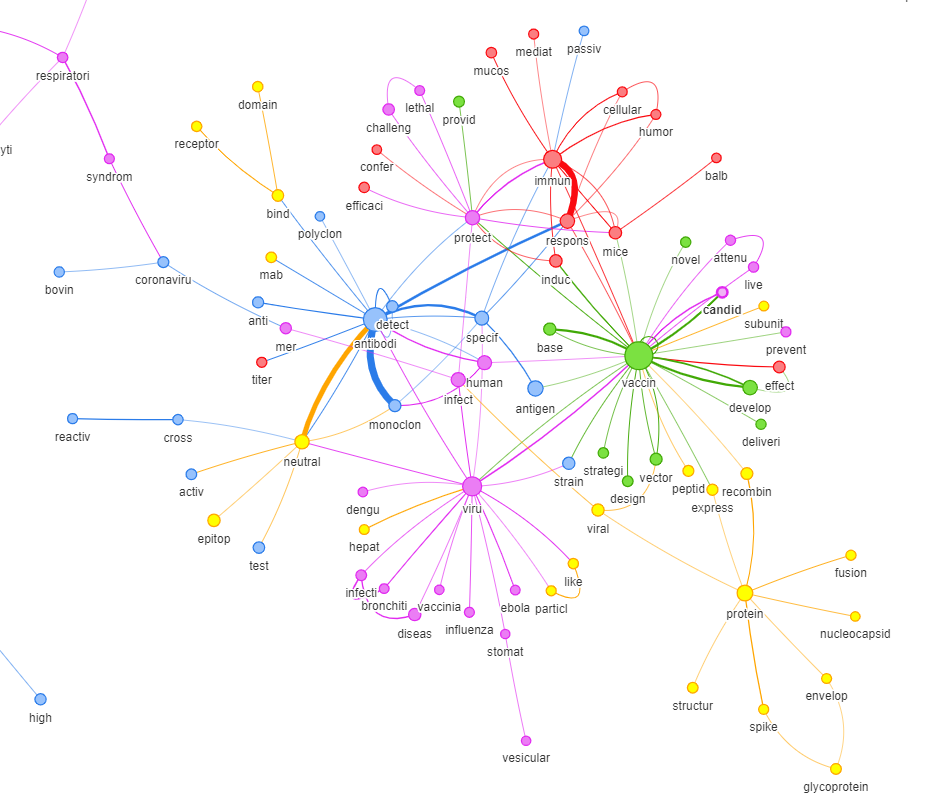

Here are all important topics that satellite around vaccine. The model seems to return valid information as corona is identified as causing respiratory disease.
The virus spike protein and the virus envelop protein seem to be the preferred way to develop a new vaccin. It seems that scientists are already investigating this approach according to recent news...

### most influencial connections among vaccin community

Show a subset of the community where the word vaccine is located (all the nodes are blue because they belong to many community). We display nodes with the strongest relationships. The following query is defined in html file for visualization that relies on neovis.js (ref:appendix).
> MATCH (w1:Word{name:'vaccin'}) WITH w1 AS word_interest, w1.group as group_interest MATCH (w2:Word)-[r:NEXT]-(w3:Word) WHERE w2.group = group_interest AND w3.group = group_interest RETURN word_interest,w2,w3,r, r.count AS rank ORDER BY rank DESC LIMIT 300

In [ ]:
if workWithDb == True:
    IFrame(src='../input/neovis-graph/index_vaccin.html', width=1000, height=700)

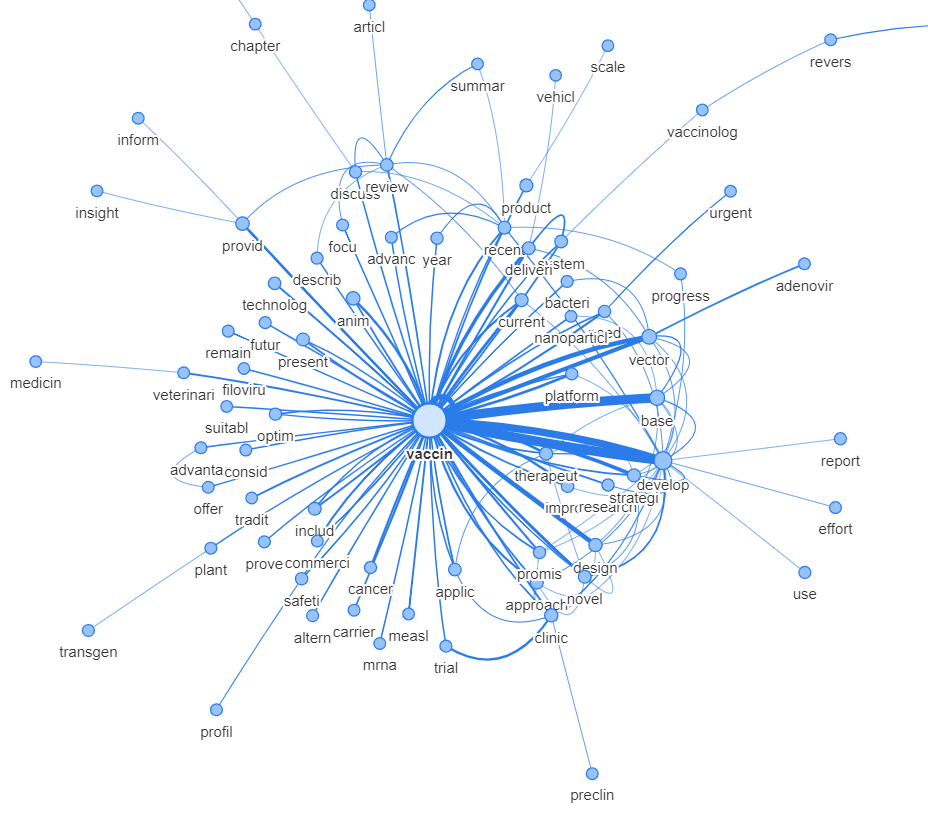

The vaccine group is also very generic. It doesnt give us relevant information. The word most related to vaccine is develop... That means  there is still work to be done. no answers yet.

### most influencial connections among antibodi community

Show a subset of the community where the word antibodies is located (all the nodes are blue because they belong to many communities). We display nodes with the strongest relationships. The following query is defined in html file for visualization that relies on neovis.js (ref:appendix).
> MATCH (w1:Word{name:'antibodi'}) WITH w1 AS word_interest, w1.group as group_interest MATCH (w2:Word)-[r:NEXT]-(w3:Word) WHERE w2.group = group_interest AND w3.group = group_interest RETURN word_interest,w2,w3,r, r.count AS rank ORDER BY rank DESC LIMIT 300

In [ ]:
if workWithDb == True:
    IFrame(src='../input/neovis-graph/index_antibodi.html', width=1000, height=700)

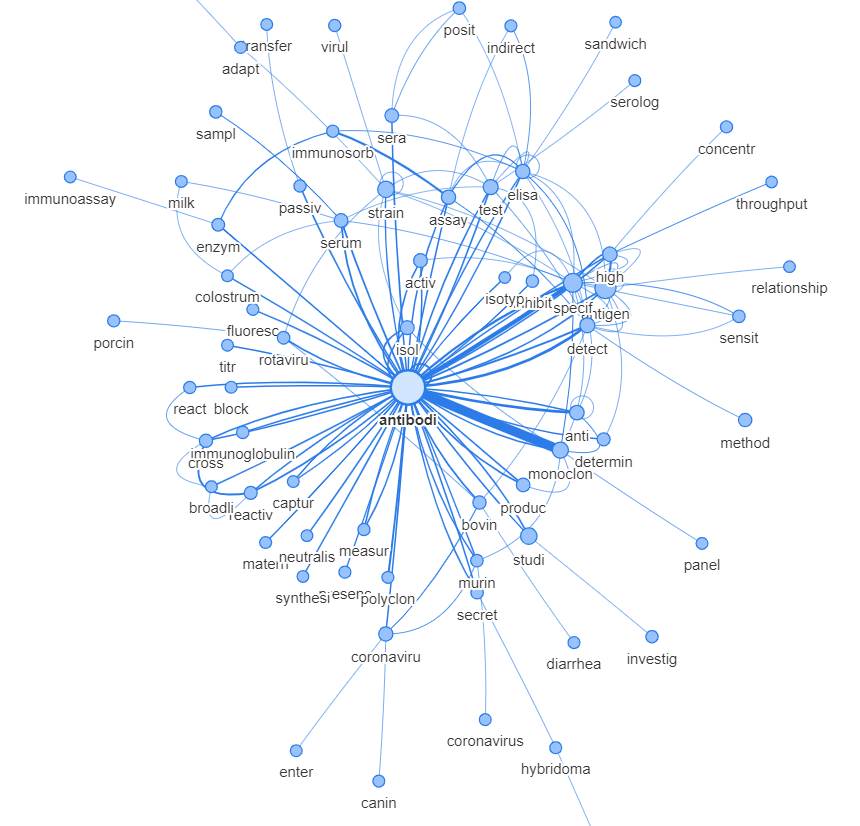

here we can see that the strongest connection to antibodies is monoclonal... it could be a lead towards the research of antibodies. We see that canin/dogs, bovin, or murin/mouse can be the best animal model for testing a vaccine prior to human.

# Outlook

We could continue the work by adding the body text to the graph. We could also increase the size of convolution window (3 in our case) connecting the words to each others. Also, we could have explore the data with the same techniques for therapeutics.

# Appendix - html scripts for graph visualization

html for:   most influencial connections among all nodes

<!doctype html>
<html>
    <head>
        <title>global_strong_relatioships</title>
        <style type="text/css">
            #viz {
                width: 900px;
                height: 700px;
            }
        </style>
		<script src="https://rawgit.com/neo4j-contrib/neovis.js/master/dist/neovis.js"></script>
    </head>
	<script>
		function draw() {
				var config = {
					container_id: "viz",
					server_url: "bolt://localhost:7687",
					server_user: "neo4j",
					server_password: "roche",
					labels: {
						"Word": {
							"caption": "name",
							"size": "pagerank",
							"community": "group"
							
						}
					},
					relationships: {
						"NEXT": {
							"thickness": "count",
							"caption": false
					}
					},
					initial_cypher: "MATCH (p1:Word)-[r:NEXT]-(p2:Word) RETURN *, r.count AS rank ORDER BY rank DESC LIMIT 300"
					
				};

				viz = new NeoVis.default(config);
				viz.render();
			}
	</script>
    <body onload="draw()">
        <div id="viz"></div>
 
		Cypher query: <textarea rows="4" cols=50 id="cypher"></textarea><br>
		<input type="submit" value="Submit" id="reload">
		<input type="submit" value="Stabilize" id="stabilize">


	</body>

	<script>
		$("#reload").click(function() {

			var cypher = $("#cypher").val();

			if (cypher.length > 3) {
				viz.renderWithCypher(cypher);
			} else {
				console.log("reload");
				viz.reload();

			}

		});

		$("#stabilize").click(function() {
			viz.stabilize();
		})

	</script>
</html>

html for:   most influencial connections among vaccin community

<!doctype html>
<html>
    <head>
        <title>vaccin_community_strong_relationships</title>
        <style type="text/css">
            #viz {
                width: 900px;
                height: 700px;
            }
        </style>
		<script src="https://rawgit.com/neo4j-contrib/neovis.js/master/dist/neovis.js"></script>
    </head>
	<script>
		function draw() {
				var config = {
					container_id: "viz",
					server_url: "bolt://localhost:7687",
					server_user: "neo4j",
					server_password: "roche",
					labels: {
						"Word": {
							"caption": "name",
							"size": "pagerank",
							"community": "group"
						}
					},
					relationships: {
						"NEXT": {
							"thickness": "count",
							"caption": false
					}
					},
					initial_cypher: "MATCH (w1:Word{name:'vaccin'}) WITH w1 AS word_interest, w1.group as group_interest MATCH (w2:Word)-[r:NEXT]-(w3:Word) WHERE w2.group = group_interest AND w3.group = group_interest RETURN word_interest,w2,w3,r, r.count AS rank ORDER BY rank DESC LIMIT 300"
					
				};

				viz = new NeoVis.default(config);
				viz.render();
			}
	</script>
    <body onload="draw()">
        <div id="viz"></div>
 
		Cypher query: <textarea rows="4" cols=50 id="cypher"></textarea><br>
		<input type="submit" value="Submit" id="reload">
		<input type="submit" value="Stabilize" id="stabilize">


	</body>

	<script>
		$("#reload").click(function() {

			var cypher = $("#cypher").val();

			if (cypher.length > 3) {
				viz.renderWithCypher(cypher);
			} else {
				console.log("reload");
				viz.reload();

			}

		});

		$("#stabilize").click(function() {
			viz.stabilize();
		})

	</script>
</html>

html for:   most influencial connections among antibodi community

<!doctype html>
<html>
    <head>
        <title>antibodi_community_strong_relationships</title>
        <style type="text/css">
            #viz {
                width: 900px;
                height: 700px;
            }
        </style>
		<script src="https://rawgit.com/neo4j-contrib/neovis.js/master/dist/neovis.js"></script>
    </head>
	<script>
		function draw() {
				var config = {
					container_id: "viz",
					server_url: "bolt://localhost:7687",
					server_user: "neo4j",
					server_password: "roche",
					labels: {
						"Word": {
							"caption": "name",
							"size": "pagerank",
							"community": "group"
						}
					},
					relationships: {
						"NEXT": {
							"thickness": "count",
							"caption": false
					}
					},
					initial_cypher: "MATCH (w1:Word{name:'antibodi'}) WITH w1 AS word_interest, w1.group as group_interest MATCH (w2:Word)-[r:NEXT]-(w3:Word) WHERE w2.group = group_interest AND w3.group = group_interest RETURN word_interest,w2,w3,r, r.count AS rank ORDER BY rank DESC LIMIT 300"
					
				};

				viz = new NeoVis.default(config);
				viz.render();
			}
	</script>
    <body onload="draw()">
        <div id="viz"></div>
 
		Cypher query: <textarea rows="4" cols=50 id="cypher"></textarea><br>
		<input type="submit" value="Submit" id="reload">
		<input type="submit" value="Stabilize" id="stabilize">


	</body>

	<script>
		$("#reload").click(function() {

			var cypher = $("#cypher").val();

			if (cypher.length > 3) {
				viz.renderWithCypher(cypher);
			} else {
				console.log("reload");
				viz.reload();

			}

		});

		$("#stabilize").click(function() {
			viz.stabilize();
		})

	</script>
</html>